# Predicting EPL Football Match Winners Using Machine Learning
In this project, we'll predict match winners in the English Premier League (EPL) using machine learning. We'll be working with match data from the English Premier League.

In [1]:
import warnings
warnings.simplefilter(action='ignore')

# EDA Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')
import seaborn as sns
%matplotlib inline

# ML Libraries
# Pre-processing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, RandomizedSearchCV

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.tree import plot_tree
from dmba import plotDecisionTree
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

no display found. Using non-interactive Agg backend


**Load Dataset**

In [2]:
matches = pd.read_csv('matches_2.csv')
matches.head()

,Season,Team,Date,Time,Comp,Round,Day,Venue,Result,GF,...,G/Sh,G/SoT,Dist,FK,PK,PKatt,npxG,npxG/Sh,G-xG,np:G-xG
0,2012-2013,Manchester United,2012-08-20,NaN,Premier League,Matchweek 1,Mon,Away,L,0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,2012-2013,Manchester United,2012-08-25,NaN,Premier League,Matchweek 2,Sat,Home,W,3,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,2012-2013,Manchester United,2012-09-02,NaN,Premier League,Matchweek 3,Sun,Away,W,3,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,2012-2013,Manchester United,2012-09-15,NaN,Premier League,Matchweek 4,Sat,Home,W,4,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,2012-2013,Manchester United,2012-09-19,NaN,Champions Lg,Group stage,Wed,Home,W,1,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN


### Data Cleaning

**Separate Premier League Fixtures**

In [3]:
epl_matches = matches.loc[matches['Comp'] == 'Premier League']
epl_matches.sample(10)

,Season,Team,Date,Time,Comp,Round,Day,Venue,Result,GF,...,G/Sh,G/SoT,Dist,FK,PK,PKatt,npxG,npxG/Sh,G-xG,np:G-xG
2636,2016-2017,Tottenham,2017-03-04,12:30,Premier League,Matchweek 27,Sat,Home,D,1,...,0.05,0.14,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN
2681,2017-2018,Tottenham,2017-12-10,16:30,Premier League,Matchweek 16,Sun,Home,L,1,...,0.13,0.20,15.6,1.0,0.0,0.0,1.4,0.22,-0.4,-0.4
7122,2012-2013,Southampton,2012-12-22,NaN,Premier League,Matchweek 18,Sat,Home,L,0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
17,2012-2013,Manchester United,2012-11-24,NaN,Premier League,Matchweek 13,Sat,Home,W,3,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3291,2018-2019,Everton,2019-01-19,15:00,Premier League,Matchweek 23,Sat,Away,L,1,...,0.14,0.50,16.8,0.0,0.0,0.0,0.9,0.14,0.1,0.1
6397,2018-2019,Fulham,2019-01-12,15:00,Premier League,Matchweek 22,Sat,Away,L,1,...,0.08,0.33,16.1,0.0,0.0,0.0,0.8,0.07,0.2,0.2
16050,2018-2019,Bournemouth,2018-10-27,15:00,Premier League,Matchweek 10,Sat,Away,W,3,...,0.18,0.50,18.8,0.0,1.0,1.0,1.2,0.11,1.0,0.8
1826,2012-2013,Arsenal,2012-11-03,NaN,Premier League,Matchweek 10,Sat,Away,L,1,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
13485,2017-2018,Crystal Palace,2017-08-12,15:00,Premier League,Matchweek 1,Sat,Home,L,0,...,0.00,0.00,18.1,3.0,0.0,0.0,1.1,0.08,-1.1,-1.1
17103,2022-2023,Brighton,2022-10-08,17:30,Premier League,Matchweek 10,Sat,Home,L,0,...,0.00,0.00,18.5,0.0,0.0,0.0,0.7,0.05,-0.7,-0.7


**Clean Datatypes**

In [4]:
epl_matches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8626 entries, 0 to 19786
Data columns (total 35 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Season        8626 non-null   object 
 1   Team          8626 non-null   object 
 2   Date          8626 non-null   object 
 3   Time          7296 non-null   object 
 4   Comp          8626 non-null   object 
 5   Round         8626 non-null   object 
 6   Day           8626 non-null   object 
 7   Venue         8626 non-null   object 
 8   Result        8424 non-null   object 
 9   GF            8424 non-null   object 
 10  GA            8424 non-null   object 
 11  Opponent      8626 non-null   object 
 12  xG            4358 non-null   float64
 13  xGA           4358 non-null   object 
 14  Poss          7094 non-null   object 
 15  Attendance    6212 non-null   object 
 16  Captain       6106 non-null   object 
 17  Formation     8424 non-null   object 
 18  Referee       8424 non-null

In [5]:
epl_matches['Date'] = pd.to_datetime(epl_matches['Date'].str.strip())

In [6]:
epl_matches['Time'] = epl_matches['Time'].str.strip()
epl_matches['Comp'] = epl_matches['Comp'].str.strip()
epl_matches['Round'] = epl_matches['Round'].str.strip()
epl_matches['Season'] = epl_matches['Season'].str.strip()
epl_matches['Day'] = epl_matches['Day'].str.strip()
epl_matches['Venue'] = epl_matches['Venue'].str.strip()
epl_matches['Result'] = epl_matches['Result'].str.strip()
epl_matches['Opponent'] = epl_matches['Opponent'].str.strip()

In [7]:
epl_matches['Attendance'] = epl_matches['Attendance'].str.replace(',','').str.strip().astype(float)

In [8]:
epl_matches['Round'] = epl_matches['Round'].str.replace('Matchweek ', '')
epl_matches['Round'] = epl_matches['Round'].astype(int)
epl_matches['Round'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 29, 34,
       35, 36, 37, 38])

In [9]:
epl_matches['GA'] = epl_matches['GA'].astype(float)
epl_matches['GF'] = epl_matches['GF'].astype(float)
epl_matches['xGA'] = epl_matches['GA'].astype(float)
epl_matches['Poss'] = epl_matches['Poss'].astype(float)

In [10]:
epl_matches.sample(10)

,Season,Team,Date,Time,Comp,Round,Day,Venue,Result,GF,...,G/Sh,G/SoT,Dist,FK,PK,PKatt,npxG,npxG/Sh,G-xG,np:G-xG
7218,2014-2015,Southampton,2015-03-21,15:00,Premier League,30,Sat,Home,W,2.0,...,0.05,0.33,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
7134,2012-2013,Southampton,2013-03-09,NaN,Premier League,29,Sat,Away,D,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
17376,2018-2019,Huddersfield,2019-05-12,15:00,Premier League,38,Sun,Away,D,1.0,...,0.10,0.33,22.2,0.0,0.0,0.0,0.7,0.07,0.3,0.3
2660,2017-2018,Tottenham,2017-08-26,17:30,Premier League,3,Sat,Home,W,2.0,...,0.10,0.33,19.6,1.0,0.0,1.0,2.0,0.10,-0.8,0.0
8496,2021-2022,Newcastle United,2021-12-16,20:00,Premier League,17,Thu,Away,L,1.0,...,0.20,0.33,31.4,2.0,0.0,0.0,0.3,0.05,0.7,0.7
7752,2015-2016,Aston Villa,2016-04-09,15:00,Premier League,33,Sat,Home,L,1.0,...,0.17,1.00,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
14638,2014-2015,Leicester City,2014-12-26,15:00,Premier League,18,Fri,Home,L,1.0,...,0.05,0.17,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
610,2012-2013,Manchester City,2012-10-06,NaN,Premier League,7,Sat,Home,W,3.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
15963,2016-2017,Bournemouth,2016-10-15,15:00,Premier League,8,Sat,Home,W,6.0,...,0.23,0.50,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN
1899,2013-2014,Arsenal,2014-03-22,NaN,Premier League,31,Sat,Away,L,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN


**Sort Dataframe by Date**

In [11]:
epl_matches.sort_values(by='Date', inplace = True)
epl_matches.reset_index(inplace=True)
epl_matches.drop(columns='index', inplace=True)
epl_matches.tail(10)

,Season,Team,Date,Time,Comp,Round,Day,Venue,Result,GF,...,G/Sh,G/SoT,Dist,FK,PK,PKatt,npxG,npxG/Sh,G-xG,np:G-xG
8616,2022-2023,Aston Villa,2023-05-28,15:00,Premier League,38,Sun,Home,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8617,2022-2023,Fulham,2023-05-28,15:00,Premier League,38,Sun,Away,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8618,2022-2023,Liverpool,2023-05-28,15:00,Premier League,38,Sun,Away,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8619,2022-2023,Manchester City,2023-05-28,15:00,Premier League,38,Sun,Away,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8620,2022-2023,Leicester City,2023-05-28,15:00,Premier League,38,Sun,Home,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8621,2022-2023,Leeds United,2023-05-28,15:00,Premier League,38,Sun,Home,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8622,2022-2023,Bournemouth,2023-05-28,15:00,Premier League,38,Sun,Away,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8623,2022-2023,Southampton,2023-05-28,15:00,Premier League,38,Sun,Home,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8624,2022-2023,Manchester United,2023-05-28,15:00,Premier League,38,Sun,Home,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8625,2022-2023,Nottingham Forest,2023-05-28,15:00,Premier League,38,Sun,Away,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Drop Future Fixtures**

In [12]:
future_matches = epl_matches.loc[epl_matches['Date'] >= '2023-04-04']
future_matches.head()

,Season,Team,Date,Time,Comp,Round,Day,Venue,Result,GF,...,G/Sh,G/SoT,Dist,FK,PK,PKatt,npxG,npxG/Sh,G-xG,np:G-xG
8426,2022-2023,Leicester City,2023-04-04,19:45,Premier League,7,Tue,Home,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8427,2022-2023,Leeds United,2023-04-04,19:45,Premier League,7,Tue,Home,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8428,2022-2023,Bournemouth,2023-04-04,19:45,Premier League,7,Tue,Home,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8429,2022-2023,Nottingham Forest,2023-04-04,19:45,Premier League,7,Tue,Away,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8430,2022-2023,Aston Villa,2023-04-04,19:45,Premier League,7,Tue,Away,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
epl_matches.drop(future_matches.index, axis=0, inplace=True)
epl_matches['Date'].max()

Timestamp('2023-04-03 00:00:00')

**Remove Duplicate Records**

In [14]:
df = epl_matches.copy()
df.sample(5)

,Season,Team,Date,Time,Comp,Round,Day,Venue,Result,GF,...,G/Sh,G/SoT,Dist,FK,PK,PKatt,npxG,npxG/Sh,G-xG,np:G-xG
2058,2014-2015,QPR,2015-03-14,12:45,Premier League,29,Sat,Away,L,1.0,...,0.09,0.25,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3398,2016-2017,Manchester United,2016-10-23,16:00,Premier League,9,Sun,Away,L,0.0,...,0.00,0.00,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
5265,2018-2019,Manchester City,2019-01-14,20:00,Premier League,22,Mon,Home,W,3.0,...,0.04,0.13,20.3,0.0,1.0,1.0,2.1,0.09,-0.8,-1.1
2239,2014-2015,Crystal Palace,2015-05-09,17:30,Premier League,36,Sat,Home,L,1.0,...,0.08,0.25,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1527,2014-2015,Burnley,2014-10-18,15:00,Premier League,8,Sat,Home,L,1.0,...,0.06,0.50,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [15]:
df.loc[df.duplicated()].head()

,Season,Team,Date,Time,Comp,Round,Day,Venue,Result,GF,...,G/Sh,G/SoT,Dist,FK,PK,PKatt,npxG,npxG/Sh,G-xG,np:G-xG
1336,2014-2015,Crystal Palace,2014-08-16,17:30,Premier League,1,Sat,Away,L,1.0,...,0.25,0.5,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1338,2014-2015,Crystal Palace,2014-08-16,17:30,Premier League,1,Sat,Away,L,1.0,...,0.25,0.5,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1339,2014-2015,Crystal Palace,2014-08-16,17:30,Premier League,1,Sat,Away,L,1.0,...,0.25,0.5,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1343,2014-2015,QPR,2014-08-16,15:00,Premier League,1,Sat,Home,L,0.0,...,0.00,0.0,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN
1347,2014-2015,QPR,2014-08-16,15:00,Premier League,1,Sat,Home,L,0.0,...,0.00,0.0,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN


In [16]:
df.drop_duplicates(keep='first', inplace=True)
df.shape

(7970, 35)

### Data Analysis

**How Many Seasons are in the Dataset**

There are 11 seasons in the dataset: 2012-2013 to 2022-2023 season.

In [17]:
df['Season'].value_counts(dropna=False).sort_index()

2012-2013    684
2013-2014    646
2014-2015    760
2015-2016    760
2016-2017    760
2017-2018    760
2018-2019    760
2019-2020    760
2020-2021    760
2021-2022    760
2022-2023    560
Name: Season, dtype: int64

In [18]:
seasons = df['Season'].value_counts(dropna=False).sort_index()

plt.barh(seasons.index, seasons)
ax = plt.gca()
ax.invert_yaxis()
plt.title('Games Per Season')
plt.xlabel('Games')
plt.show()

**Why are Some Season Games Less Than Others?**

In the EPL, each team plays 38 games and there are 380 matches in the season (played between 2 teams). Our dataset records games from each teams' perspective, which doubles the total number of games played as there are 2 records (one for each team) for every game played.

The 2022-2023 season is still ongoing and this explains why the season has less than 760 games.

However, the 2012-13 ane 2013-14 season have under 700 records each. This implies the existence of missing records.

In [19]:
df.loc[df['Season'] == '2012-2013']['Team'].unique()

array(['Fulham', 'Sunderland', 'Liverpool', 'West Bromwich Albion',
       'Swansea City', 'Arsenal', 'West Ham United', 'Norwich City',
       'Newcastle United', 'Stoke City', 'Aston Villa', 'Wigan Athletic',
       'Chelsea', 'Manchester City', 'Southampton', 'Tottenham',
       'Manchester United', 'Everton'], dtype=object)

In [20]:
df.loc[df['Season'] == '2013-2014']['Team'].unique()

array(['Norwich City', 'Everton', 'Southampton', 'Fulham', 'Liverpool',
       'Swansea City', 'Stoke City', 'West Bromwich Albion',
       'West Ham United', 'Manchester United', 'Aston Villa', 'Arsenal',
       'Sunderland', 'Tottenham', 'Chelsea', 'Manchester City',
       'Newcastle United'], dtype=object)

**Resolution**

The discrepancies from the first 2 seasons is from the number of teams in the dataset for those seasons. When number of teams is multiplied by 38 (number of games), it reflects the number of games for those seasons.

There is no missing data.

### Cleaning Data for Machine Learning
ML models do not predict well with missing or nan data. We have to impute or drop those records. We will encode relevant categorical features for the feature selection process.

Next, we'll drop the missing records in Result, GA and GF. When we review, those records are from a match that was postponed. We'll therefore drop them.

Then we'll consider the missing records in the technical stats section. These records will be filled using imputation.

In [21]:
df.isnull().sum()

Season             0
Team               0
Date               0
Time            1330
Comp               0
Round              0
Day                0
Venue              0
Result             2
GF                 2
GA                 2
Opponent           0
xG              3612
xGA                2
Poss            1332
Attendance      2214
Captain         2092
Formation          2
Referee            2
Match Report       2
Notes           7968
Gls                2
Sh              1332
SoT             1332
SoT%            1335
G/Sh            1335
G/SoT           1538
Dist            3615
FK              3612
PK                 2
PKatt           1332
npxG            3612
npxG/Sh         3615
G-xG            3612
np:G-xG         3612
dtype: int64

In [22]:
df.loc[df['GF'].isnull()]

,Season,Team,Date,Time,Comp,Round,Day,Venue,Result,GF,...,G/Sh,G/SoT,Dist,FK,PK,PKatt,npxG,npxG/Sh,G-xG,np:G-xG
8338,2022-2023,Newcastle United,2023-02-25,12:30,Premier League,25,Sat,Home,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8340,2022-2023,Brighton,2023-02-25,12:30,Premier League,25,Sat,Away,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df.drop(index=df.loc[df['GF'].isnull()].index, inplace=True)

In [24]:
# drop_cols = ['Time', 'Attendance', 'Captain',
#              'Referee', 'Match Report', 'Notes',
#              'Day', 'Comp', 'Formation']
#
# df.drop(columns=drop_cols, inplace=True)


df.sample(5)

,Season,Team,Date,Time,Comp,Round,Day,Venue,Result,GF,...,G/Sh,G/SoT,Dist,FK,PK,PKatt,npxG,npxG/Sh,G-xG,np:G-xG
3346,2016-2017,Arsenal,2016-10-02,16:30,Premier League,7,Sun,Away,W,1.0,...,0.06,0.33,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2129,2014-2015,Crystal Palace,2015-04-06,20:00,Premier League,31,Mon,Home,W,2.0,...,0.40,0.67,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2375,2015-2016,West Ham United,2015-08-22,15:00,Premier League,3,Sat,Home,L,3.0,...,0.20,0.50,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN
975,2013-2014,Swansea City,2013-12-26,NaN,Premier League,18,Thu,Away,L,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
5252,2018-2019,Fulham,2019-01-12,15:00,Premier League,22,Sat,Away,L,1.0,...,0.08,0.33,16.1,0.0,0.0,0.0,0.8,0.07,0.2,0.2


**Numeric Encoding of Categorical Variables**

We will convert Venue field into numeric using encoding.

In [25]:
df['Venue_Code'] = df['Venue'].astype('category').cat.codes

In [26]:
df['Opp_Code'] = df['Opponent'].astype('category').cat.codes

In [27]:
df['Hour'] = df['Time'].str.replace(':.+', '', regex=True).astype(float)

In [28]:
df['Day_Code'] = df['Date'].dt.dayofweek

In [29]:
df['Formation_Code'] = df['Formation'].astype('category').cat.codes

In [30]:
df.head()

,Season,Team,Date,Time,Comp,Round,Day,Venue,Result,GF,...,PKatt,npxG,npxG/Sh,G-xG,np:G-xG,Venue_Code,Opp_Code,Hour,Day_Code,Formation_Code
0,2012-2013,Fulham,2012-08-18,NaN,Premier League,1,Sat,Home,W,5.0,...,NaN,NaN,NaN,NaN,NaN,1,20,NaN,5,17
1,2012-2013,Sunderland,2012-08-18,NaN,Premier League,1,Sat,Away,D,0.0,...,NaN,NaN,NaN,NaN,NaN,0,0,NaN,5,19
2,2012-2013,Liverpool,2012-08-18,NaN,Premier League,1,Sat,Away,L,0.0,...,NaN,NaN,NaN,NaN,NaN,0,31,NaN,5,12
3,2012-2013,West Bromwich Albion,2012-08-18,NaN,Premier League,1,Sat,Home,W,3.0,...,NaN,NaN,NaN,NaN,NaN,1,15,NaN,5,12
4,2012-2013,Swansea City,2012-08-18,NaN,Premier League,1,Sat,Away,W,5.0,...,NaN,NaN,NaN,NaN,NaN,0,22,NaN,5,16


**Create Target**

We'll be using the Result Feature as the target.

In [31]:
# df['Target'] = df['Result'].apply(lambda x: 1 if x == 'W' else 0)
# df.head()

**Missing Data in the Technical Stats**

In [32]:
df.columns

Index(['Season', 'Team', 'Date', 'Time', 'Comp', 'Round', 'Day', 'Venue',
       'Result', 'GF', 'GA', 'Opponent', 'xG', 'xGA', 'Poss', 'Attendance',
       'Captain', 'Formation', 'Referee', 'Match Report', 'Notes', 'Gls', 'Sh',
       'SoT', 'SoT%', 'G/Sh', 'G/SoT', 'Dist', 'FK', 'PK', 'PKatt', 'npxG',
       'npxG/Sh', 'G-xG', 'np:G-xG', 'Venue_Code', 'Opp_Code', 'Hour',
       'Day_Code', 'Formation_Code'],
      dtype='object')

In [33]:
df.isnull().sum()

Season               0
Team                 0
Date                 0
Time              1330
Comp                 0
Round                0
Day                  0
Venue                0
Result               0
GF                   0
GA                   0
Opponent             0
xG                3610
xGA                  0
Poss              1330
Attendance        2212
Captain           2090
Formation            0
Referee              0
Match Report         0
Notes             7968
Gls                  0
Sh                1330
SoT               1330
SoT%              1333
G/Sh              1333
G/SoT             1536
Dist              3613
FK                3610
PK                   0
PKatt             1330
npxG              3610
npxG/Sh           3613
G-xG              3610
np:G-xG           3610
Venue_Code           0
Opp_Code             0
Hour              1330
Day_Code             0
Formation_Code       0
dtype: int64

In [34]:
tech_cols = list(df.columns[12:-5])
tech_cols.insert(0, 'Hour')
tech_cols.insert(0, 'Date')
tech_cols.remove('Captain')
tech_cols.remove('Formation')
tech_cols.remove('Referee')
tech_cols.remove('Match Report')
tech_cols.remove('Notes')
tech_cols

['Date',
 'Hour',
 'xG',
 'xGA',
 'Poss',
 'Attendance',
 'Gls',
 'Sh',
 'SoT',
 'SoT%',
 'G/Sh',
 'G/SoT',
 'Dist',
 'FK',
 'PK',
 'PKatt',
 'npxG',
 'npxG/Sh',
 'G-xG',
 'np:G-xG']

In [35]:
df[tech_cols].isnull().sum()

Date             0
Hour          1330
xG            3610
xGA              0
Poss          1330
Attendance    2212
Gls              0
Sh            1330
SoT           1330
SoT%          1333
G/Sh          1333
G/SoT         1536
Dist          3613
FK            3610
PK               0
PKatt         1330
npxG          3610
npxG/Sh       3613
G-xG          3610
np:G-xG       3610
dtype: int64

In [36]:
df[tech_cols].loc[df[tech_cols[1]].isnull()].Date.dt.year.unique()

array([2012, 2013, 2014])

The empty values in the technical stats section are all from earlier seasons. We'll replace those values with 0.

In [37]:
imp = SimpleImputer(missing_values=np.nan,
                    strategy='constant',
                    fill_value= 0)

df[tech_cols[1:]] = imp.fit_transform(df[tech_cols[1:]])
df.isnull().sum()

Season               0
Team                 0
Date                 0
Time              1330
Comp                 0
Round                0
Day                  0
Venue                0
Result               0
GF                   0
GA                   0
Opponent             0
xG                   0
xGA                  0
Poss                 0
Attendance           0
Captain           2090
Formation            0
Referee              0
Match Report         0
Notes             7968
Gls                  0
Sh                   0
SoT                  0
SoT%                 0
G/Sh                 0
G/SoT                0
Dist                 0
FK                   0
PK                   0
PKatt                0
npxG                 0
npxG/Sh              0
G-xG                 0
np:G-xG              0
Venue_Code           0
Opp_Code             0
Hour                 0
Day_Code             0
Formation_Code       0
dtype: int64

In [38]:
df[tech_cols[1:]] = df[tech_cols[1:]].astype(float)

**Selecting Predictors**

In [39]:
df['Result_Code'] = df['Result'].astype('category').cat.codes

df.corr()

,Round,GF,GA,xG,xGA,Poss,Attendance,Gls,Sh,SoT,...,npxG,npxG/Sh,G-xG,np:G-xG,Venue_Code,Opp_Code,Hour,Day_Code,Formation_Code,Result_Code
Round,1.000000,-0.009407,-0.003875,-0.019641,-0.003875,-0.012265,-0.059338,-0.005905,-0.014414,-0.009638,...,-0.017064,-0.013867,-0.011234,-0.011421,0.000300,0.006257,0.016549,-0.063566,0.015389,0.032028
GF,-0.009407,1.000000,-0.120095,0.302305,-0.120095,0.049429,0.007523,0.985268,0.189801,0.409078,...,0.279442,0.161993,0.567665,0.559636,0.127388,0.019187,-0.036865,0.016382,-0.020523,0.504703
GA,-0.003875,-0.120095,1.000000,-0.096792,1.000000,-0.079400,0.015010,-0.121059,-0.117287,-0.116591,...,-0.098097,-0.022469,-0.023537,-0.024065,-0.123439,-0.046340,-0.000840,0.020994,0.026290,-0.223785
xG,-0.019641,0.302305,-0.096792,1.000000,-0.096792,0.427409,0.147824,0.306196,0.500579,0.483724,...,0.970495,0.827242,-0.010087,-0.010686,0.078003,-0.081321,0.368222,-0.014286,-0.039772,0.167285
xGA,-0.003875,-0.120095,1.000000,-0.096792,1.000000,-0.079400,0.015010,-0.121059,-0.117287,-0.116591,...,-0.098097,-0.022469,-0.023537,-0.024065,-0.123439,-0.046340,-0.000840,0.020994,0.026290,-0.223785
Poss,-0.012265,0.049429,-0.079400,0.427409,-0.079400,1.000000,0.477402,0.053345,0.799217,0.647491,...,0.430456,0.337540,-0.027186,-0.026354,0.047335,-0.032123,0.808395,-0.021734,-0.112455,0.029627
Attendance,-0.059338,0.007523,0.015010,0.147824,0.015010,0.477402,1.000000,0.011546,0.413457,0.362726,...,0.153371,0.147766,0.013364,0.016520,0.020909,-0.024231,0.491035,0.049335,-0.049875,0.006698
Gls,-0.005905,0.985268,-0.121059,0.306196,-0.121059,0.053345,0.011546,1.000000,0.192045,0.416325,...,0.282119,0.165584,0.579009,0.570952,0.124673,0.018427,-0.032202,0.015768,-0.018790,0.499968
Sh,-0.014414,0.189801,-0.117287,0.500579,-0.117287,0.799217,0.413457,0.192045,1.000000,0.799857,...,0.515411,0.257534,-0.060520,-0.057729,0.153519,-0.039664,0.643943,-0.007658,-0.069487,0.091063
SoT,-0.009638,0.409078,-0.116591,0.483724,-0.116591,0.647491,0.362726,0.416325,0.799857,1.000000,...,0.498483,0.307820,0.164774,0.167213,0.112331,-0.028011,0.536974,-0.004392,-0.068122,0.213267


In [40]:
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(),
            annot=True,
            linewidths=0.5,
            fmt= ".2f",
            cmap="YlGnBu")

<Axes: >

The top 10 features correlated with result are:

In [41]:
corr_features = ['GF', 'GA', 'xG', 'xGA', 'Gls', 'SoT', 'G/Sh', 'G/SoT', 'G-xG', 'np:G-xG']
corr_features

['GF', 'GA', 'xG', 'xGA', 'Gls', 'SoT', 'G/Sh', 'G/SoT', 'G-xG', 'np:G-xG']

**Separating Features & Target**

In [42]:
numeric_features = list(df.corr().columns[:-1])
numeric_features

['Round',
 'GF',
 'GA',
 'xG',
 'xGA',
 'Poss',
 'Attendance',
 'Gls',
 'Sh',
 'SoT',
 'SoT%',
 'G/Sh',
 'G/SoT',
 'Dist',
 'FK',
 'PK',
 'PKatt',
 'npxG',
 'npxG/Sh',
 'G-xG',
 'np:G-xG',
 'Venue_Code',
 'Opp_Code',
 'Hour',
 'Day_Code',
 'Formation_Code']

In [43]:
X = df[numeric_features]
y = df['Result'].apply(lambda x: 0 if x == 'L' else (1 if x == 'D' else 2))

y.head()

0    2
1    1
2    0
3    2
4    2
Name: Result, dtype: int64

**Scale Predictor Features**

Classification algorithms work well with scaled features. We'll be using the Standard Scaler.

In [44]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=numeric_features)

X.head()

,Round,GF,GA,xG,xGA,Poss,Attendance,Gls,Sh,SoT,...,PKatt,npxG,npxG/Sh,G-xG,np:G-xG,Venue_Code,Opp_Code,Hour,Day_Code,Formation_Code
0,-1.673173,2.882042,-1.077559,-0.823374,-1.077559,-1.915748,-1.231828,2.972950,-1.533985,-1.278836,...,-0.328474,-0.821016,-0.901117,0.001823,0.002612,1.0,0.347365,-2.102556,0.3242,0.888588
1,-1.673173,-1.092225,-1.077559,-0.823374,-1.077559,-1.915748,-1.231828,-1.075115,-1.533985,-1.278836,...,-0.328474,-0.821016,-0.901117,0.001823,0.002612,-1.0,-1.596726,-2.102556,0.3242,1.332506
2,-1.673173,-1.092225,1.298199,-0.823374,1.298199,-1.915748,-1.231828,-1.075115,-1.533985,-1.278836,...,-0.328474,-0.821016,-0.901117,0.001823,0.002612,-1.0,1.416614,-2.102556,0.3242,-0.221207
3,-1.673173,1.292335,-1.077559,-0.823374,-1.077559,-1.915748,-1.231828,1.353724,-1.533985,-1.278836,...,-0.328474,-0.821016,-0.901117,0.001823,0.002612,1.0,-0.138658,-2.102556,0.3242,-0.221207
4,-1.673173,2.882042,-1.077559,-0.823374,-1.077559,-1.915748,-1.231828,2.972950,-1.533985,-1.278836,...,-0.328474,-0.821016,-0.901117,0.001823,0.002612,-1.0,0.541774,-2.102556,0.3242,0.666629


**Features that Covary - Principal Component Analysis**

In [45]:
prod_pca = PCA(n_components=5)
prod_pca.fit(X)

exp_var = pd.DataFrame(prod_pca.explained_variance_)
ax = exp_var.head(10).plot.bar(legend=False, figsize=(4, 4))
ax.set_xlabel('Component')
plt.show()

In [46]:
pca_comp = pd.DataFrame(prod_pca.components_, columns=X.columns).loc[0].sort_values(ascending=False)
pca_comp

SoT               0.304874
xG                0.293005
npxG              0.289509
SoT%              0.278092
Poss              0.273725
Sh                0.270434
G/Sh              0.266556
Hour              0.263325
npxG/Sh           0.261746
G/SoT             0.241490
Dist              0.221175
Gls               0.215839
GF                0.212336
Attendance        0.160815
G-xG              0.137819
np:G-xG           0.137269
FK                0.136363
PKatt             0.095480
PK                0.055243
Venue_Code        0.039442
Round            -0.008845
Day_Code         -0.016654
Opp_Code         -0.031469
Formation_Code   -0.032300
xGA              -0.053716
GA               -0.053716
Name: 0, dtype: float64

The top 10 features that covary are:

In [47]:
pca_features = list(pca_comp.index[:10])
pca_features

['SoT', 'xG', 'npxG', 'SoT%', 'Poss', 'Sh', 'G/Sh', 'Hour', 'npxG/Sh', 'G/SoT']

**Parameter Tuning for Models & Feature Selection**

*Logistic Regression*

In [48]:
lrm = LogisticRegression()
params = {'penalty':[None, 'l2', 'l1', 'elasticnet'],
          'solver':['lbfgs', 'newton_cg', 'sag', 'saga'],
          'C':range(1, 11)}

grid_recall = GridSearchCV(lrm, param_grid=params,
                           scoring='accuracy', n_jobs=-1)

grid_recall.fit(X, y)
best_params = grid_recall.best_params_
best_score = grid_recall.best_score_
best_estimator = grid_recall.best_estimator_

print(best_params)
print(best_score)
print(best_estimator)

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached w

{'C': 4, 'penalty': 'l2', 'solver': 'lbfgs'}
1.0
LogisticRegression(C=4)


In [49]:
lrm = LogisticRegression(C=3, penalty='l2', solver='lbfgs')

forward = SequentialFeatureSelector(estimator=lrm,
                                    n_features_to_select=10,
                                    direction="forward")
forward.fit(X, y)
lrm_ff = forward.get_feature_names_out()
print('Forward Features: ', lrm_ff)



backward = SequentialFeatureSelector(estimator=lrm,
                                     n_features_to_select=10,
                                     direction="backward")
backward.fit(X, y)
lrm_bb = backward.get_feature_names_out()
print('Backward Features: ', lrm_bb)

Forward Features:  ['Round' 'GF' 'GA' 'xG' 'xGA' 'Poss' 'Attendance' 'Sh' 'SoT' 'SoT%']
Backward Features:  ['GF' 'xGA' 'npxG/Sh' 'G-xG' 'np:G-xG' 'Venue_Code' 'Opp_Code' 'Hour'
 'Day_Code' 'Formation_Code']


*KNeighbors Classifier*

In [50]:
knnm = KNeighborsClassifier()
params = {"n_neighbors": range(1, 11),
          'weights':['uniform', 'distance'],
          "metric": ["minkowski", "manhattan"]}

grid_recall = GridSearchCV(knnm, params,
                           scoring='accuracy', n_jobs=-1)

grid_recall.fit(X, y)
best_params = grid_recall.best_params_
best_score = grid_recall.best_score_
best_estimator = grid_recall.best_estimator_

print(best_params)
print(best_score)
print(best_estimator)

{'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}
0.8416376225661045
KNeighborsClassifier(metric='manhattan', n_neighbors=10, weights='distance')


In [51]:
knnm = KNeighborsClassifier(metric='manhattan', n_neighbors=10,
                            weights='distance')

forward = SequentialFeatureSelector(estimator=knnm,
                                    n_features_to_select=10,
                                    direction="forward")
forward.fit(X, y)
knn_ff = forward.get_feature_names_out()
print('Forward Features: ', knn_ff)



backward = SequentialFeatureSelector(estimator=knnm,
                                     n_features_to_select=10,
                                     direction="backward")
backward.fit(X, y)
knn_bb = backward.get_feature_names_out()
print('Backward Features: ', knn_bb)

Forward Features:  ['Round' 'GF' 'GA' 'xGA' 'Poss' 'Attendance' 'Gls' 'Venue_Code' 'Hour'
 'Formation_Code']
Backward Features:  ['GF' 'GA' 'xG' 'xGA' 'Poss' 'Attendance' 'Gls' 'Dist' 'npxG/Sh' 'Hour']


*Stochastic Gradient Classifier*

In [52]:
sgdm = SGDClassifier()
params = {"loss": ['hinge', 'modified_huber', 'log_loss'],
          'penalty':['l2', 'l1', 'elasticnet']}

grid_recall = GridSearchCV(sgdm, params,
                           scoring='accuracy', n_jobs=-1)

grid_recall.fit(X, y)
best_params = grid_recall.best_params_
best_score = grid_recall.best_score_
best_estimator = grid_recall.best_estimator_

print(best_params)
print(best_score)
print(best_estimator)

{'loss': 'hinge', 'penalty': 'l1'}
0.9961101777617101
SGDClassifier(penalty='l1')


In [53]:
sgdm = SGDClassifier(loss='log_loss', penalty='l1')

forward = SequentialFeatureSelector(estimator=sgdm,
                                    n_features_to_select=10,
                                    direction="forward")
forward.fit(X, y)
sgd_ff = forward.get_feature_names_out()
print('Forward Features: ', sgd_ff)



backward = SequentialFeatureSelector(estimator=sgdm,
                                     n_features_to_select=10,
                                     direction="backward")
backward.fit(X, y)
sgd_bb = backward.get_feature_names_out()
print('Backward Features: ', sgd_bb)

Forward Features:  ['Round' 'GF' 'GA' 'xG' 'xGA' 'Poss' 'Attendance' 'Sh' 'SoT' 'SoT%']
Backward Features:  ['Round' 'GF' 'GA' 'Attendance' 'G/SoT' 'npxG' 'npxG/Sh' 'G-xG' 'np:G-xG'
 'Venue_Code']


*Support Vector Machine*

In [54]:
svcm = SVC()
params = {"C": range(1, 10), 
          'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 
          'gamma':['auto', 'scale']}

grid_recall = GridSearchCV(svcm, params,
                           scoring='accuracy', n_jobs=-1)

grid_recall.fit(X, y)
best_params = grid_recall.best_params_
best_score = grid_recall.best_score_
best_estimator = grid_recall.best_estimator_

print(best_params)
print(best_score)
print(best_estimator)

{'C': 1, 'gamma': 'auto', 'kernel': 'linear'}
1.0
SVC(C=1, gamma='auto', kernel='linear')


In [55]:
svcm = SVC(C=1, gamma='auto', kernel='linear')
forward = SequentialFeatureSelector(estimator=svcm,
                                    n_features_to_select=10,
                                    direction="forward")
forward.fit(X, y)
svc_ff = forward.get_feature_names_out()
print('Forward Features: ', svc_ff)



backward = SequentialFeatureSelector(estimator=svcm,
                                     n_features_to_select=10,
                                     direction="backward")
backward.fit(X, y)
svc_bb = backward.get_feature_names_out()
print('Backward Features: ', svc_bb)

Forward Features:  ['Round' 'GF' 'GA' 'xG' 'xGA' 'Poss' 'Attendance' 'Gls' 'Sh' 'SoT']
Backward Features:  ['GF' 'xGA' 'npxG/Sh' 'G-xG' 'np:G-xG' 'Venue_Code' 'Opp_Code' 'Hour'
 'Day_Code' 'Formation_Code']


*Gaussian Naive Bayes*

In [56]:
gnbm = GaussianNB()
forward = SequentialFeatureSelector(estimator=gnbm,
                                    n_features_to_select=10,
                                    direction="forward")
forward.fit(X, y)
gnb_ff = forward.get_feature_names_out()
print('Forward Features: ', gnb_ff)



backward = SequentialFeatureSelector(estimator=gnbm,
                                     n_features_to_select=10,
                                     direction="backward")
backward.fit(X, y)
gnb_bb = backward.get_feature_names_out()
print('Backward Features: ', gnb_bb)

Forward Features:  ['Round' 'GF' 'GA' 'Attendance' 'Dist' 'Venue_Code' 'Opp_Code' 'Hour'
 'Day_Code' 'Formation_Code']
Backward Features:  ['GF' 'GA' 'xG' 'xGA' 'Gls' 'G/SoT' 'Dist' 'PK' 'Hour' 'Formation_Code']


*Decision Tree Classifier*

In [57]:
dtm = DecisionTreeClassifier(random_state=24)
params = {'criterion': ['gini', 'entropy'],
          'class_weight': [None, 'balanced'],
          'min_samples_split': list(range(12, 48, 3)),
          'max_depth': list(range(3, 7)),
          'min_samples_leaf': list(range(9, 19, 3))}

grid_recall = GridSearchCV(dtm, param_grid=params,
                           scoring='accuracy', n_jobs=-1)

grid_recall.fit(X, y)
best_params = grid_recall.best_params_
best_score = grid_recall.best_score_
best_estimator = grid_recall.best_estimator_

print(best_params)
print(best_score)
print(best_estimator)

{'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 9, 'min_samples_split': 12}
0.9992471769134254
DecisionTreeClassifier(max_depth=6, min_samples_leaf=9, min_samples_split=12,
                       random_state=24)


In [58]:
dtm = DecisionTreeClassifier(criterion='gini', max_depth=6, 
                             min_samples_leaf=9, min_samples_split=12, 
                             random_state=24)
forward = SequentialFeatureSelector(estimator=dtm,
                                    n_features_to_select=10,
                                    direction="forward")
forward.fit(X, y)
dt_ff = forward.get_feature_names_out()
print('Forward Features: ', dt_ff)



backward = SequentialFeatureSelector(estimator=dtm,
                                     n_features_to_select=10,
                                     direction="backward")
backward.fit(X, y)
dt_bb = backward.get_feature_names_out()
print('Backward Features: ', dt_bb)

Forward Features:  ['Round' 'GF' 'GA' 'xG' 'xGA' 'Poss' 'Attendance' 'Gls' 'Sh' 'SoT']
Backward Features:  ['GF' 'GA' 'npxG/Sh' 'G-xG' 'np:G-xG' 'Venue_Code' 'Opp_Code' 'Hour'
 'Day_Code' 'Formation_Code']


*Random Forest Classifier*

In [59]:
rfm = RandomForestClassifier()
params = {'criterion': ['gini', 'entropy'],
          'n_estimators':[50, 70, 100, 150],
          'class_weight': [None, 'balanced'],
          'min_samples_split': list(range(12, 48, 3)),
          'max_depth': list(range(3, 7)),
          'min_samples_leaf': list(range(9, 19, 3))}

class_tree= RandomForestClassifier(random_state=24)
random_recall = RandomizedSearchCV(rfm,
                                   param_distributions=params,
                                   scoring='accuracy',
                                   n_iter=10,
                                   cv=9,
                                   n_jobs=-1)

random_recall.fit(X, y)
best_params = random_recall.best_params_
best_score = random_recall.best_score_
best_estimator = random_recall.best_estimator_

print(best_params)
print(best_score)
print(best_estimator)

{'n_estimators': 70, 'min_samples_split': 45, 'min_samples_leaf': 9, 'max_depth': 6, 'criterion': 'gini', 'class_weight': None}
0.9887062331107173
RandomForestClassifier(max_depth=6, min_samples_leaf=9, min_samples_split=45,
                       n_estimators=70)


In [60]:
rfm = RandomForestClassifier(criterion='entropy', max_depth=6, min_samples_leaf=12,
                             min_samples_split=45, n_estimators=70)
forward = SequentialFeatureSelector(estimator=rfm,
                                    n_features_to_select=10,
                                    direction="forward")
forward.fit(X, y)
rf_ff = forward.get_feature_names_out()
print('Forward Features: ', rf_ff)



backward = SequentialFeatureSelector(estimator=rfm,
                                     n_features_to_select=10,
                                     direction="backward")
backward.fit(X, y)
rf_bb = backward.get_feature_names_out()
print('Backward Features: ', rf_bb)

Forward Features:  ['Round' 'GF' 'GA' 'xG' 'xGA' 'Gls' 'Dist' 'FK' 'npxG/Sh' 'Day_Code']
Backward Features:  ['Round' 'GF' 'GA' 'xGA' 'Poss' 'Attendance' 'Gls' 'PKatt' 'npxG/Sh'
 'Opp_Code']


**Final Feature Selection**

In [61]:
model_predictors = [corr_features, pca_features, lrm_ff, lrm_bb, 
                    knn_ff, knn_bb, sgd_ff, sgd_bb, svc_ff, svc_bb, 
                    gnb_ff, gnb_bb, dt_ff, dt_bb, rf_ff, rf_bb]

unique_predictors = list({mod for model in model_predictors for mod in model})
unique_predictors

['FK',
 'GA',
 'xGA',
 'np:G-xG',
 'Attendance',
 'npxG/Sh',
 'Hour',
 'npxG',
 'Venue_Code',
 'Opp_Code',
 'Dist',
 'G/SoT',
 'SoT%',
 'Gls',
 'PKatt',
 'Poss',
 'PK',
 'G-xG',
 'Formation_Code',
 'GF',
 'Sh',
 'Round',
 'G/Sh',
 'SoT',
 'Day_Code',
 'xG']

In [62]:
pred_count = dict()
for model in model_predictors:
    for mod in model:
        if mod not in pred_count:
            pred_count[mod] = 1
        else:
            pred_count[mod] += 1

pred_count

{'GF': 15,
 'GA': 13,
 'xG': 9,
 'xGA': 12,
 'Gls': 8,
 'SoT': 6,
 'G/Sh': 2,
 'G/SoT': 4,
 'G-xG': 5,
 'np:G-xG': 5,
 'npxG': 2,
 'SoT%': 3,
 'Poss': 8,
 'Sh': 5,
 'Hour': 8,
 'npxG/Sh': 8,
 'Round': 9,
 'Attendance': 9,
 'Venue_Code': 6,
 'Opp_Code': 5,
 'Day_Code': 5,
 'Formation_Code': 6,
 'Dist': 4,
 'PK': 1,
 'FK': 1,
 'PKatt': 1}

**Model Evaluation - Cross Validation**

In [63]:
logres_cv = cross_val_score(lrm, X[unique_predictors], y, cv=5, scoring="neg_mean_squared_error")

print("Logistic Regression Model, Avg MSE: ", np.mean(logres_cv))
print("Logistic Regression Model, MSE St. Dev.: ", np.std(logres_cv))

Logistic Regression Model, Avg MSE:  -0.00012554927809165097
Logistic Regression Model, MSE St. Dev.:  0.00025109855618330194


In [64]:
knn_cv = cross_val_score(knnm, X[unique_predictors], y, cv=5, scoring="neg_mean_squared_error")

print("KNeighbors Model, Avg MSE: ", np.mean(knn_cv))
print("KNeighbors Model, MSE St. Dev.: ", np.std(knn_cv))

KNeighbors Model, Avg MSE:  -0.24719999117846977
KNeighbors Model, MSE St. Dev.:  0.31701600290509935


In [65]:
sgd_cv = cross_val_score(sgdm, X[unique_predictors], y, cv=5, scoring="neg_mean_squared_error")

print("Stochastic Gradient Model, Avg MSE: ", np.mean(sgd_cv))
print("Stochastic Gradient Model, MSE St. Dev.: ", np.std(sgd_cv))

Stochastic Gradient Model, Avg MSE:  -0.03249717829178944
Stochastic Gradient Model, MSE St. Dev.:  0.06374628237103795


In [66]:
gnb_cv = cross_val_score(gnbm, X[unique_predictors], y, cv=5, scoring="neg_mean_squared_error")

print("Naive Bayes Model, Avg MSE: ", np.mean(gnb_cv))
print("Naive Bayes Model, MSE St. Dev.: ", np.std(gnb_cv))

Naive Bayes Model, Avg MSE:  -0.37146431887941367
Naive Bayes Model, MSE St. Dev.:  0.21407843322784162


In [67]:
dt_cv = cross_val_score(dtm, X[unique_predictors], y, cv=5, scoring="neg_mean_squared_error")

print("Decision Tree Model, Avg MSE: ", np.mean(dt_cv))
print("Decision Tree Model, MSE St. Dev.: ", np.std(dt_cv))

Decision Tree Model, Avg MSE:  -0.0018820577164366374
Decision Tree Model, MSE St. Dev.:  0.0018610284785685477


In [68]:
rf_cv = cross_val_score(rfm, X[unique_predictors], y, cv=5, scoring="neg_mean_squared_error")

print("Random Forest Model, Avg MSE: ", np.mean(rf_cv))
print("Random Forest Model, MSE St. Dev.: ", np.std(rf_cv))

Random Forest Model, Avg MSE:  -0.027356037746697637
Random Forest Model, MSE St. Dev.:  0.02884187123005461


The MSEs on the models are very good. We'll use them for Training & Testing.

### Training an Initial ML Model

**Train Test Split**

We'll be using all records from 2021 as test data.

In [69]:
df.loc[df['Date'].dt.year >= 2021].shape[0]

1768

In [70]:
tss = TimeSeriesSplit(n_splits=3, test_size=1768)
for train_index, test_index in tss.split(X[unique_predictors]):
    X_train, X_test = X[unique_predictors].iloc[train_index, :], X[unique_predictors].iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

**Testing the Logistic Model**

In [71]:
lrm.fit(X_train, y_train)
y_pred_lrm = lrm.predict(X_test)

lrm.score(X_train, y_train)

1.0

In [72]:
print(classification_report(y_test, y_pred_lrm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       678
           1       1.00      1.00      1.00       410
           2       1.00      1.00      1.00       680

    accuracy                           1.00      1768
   macro avg       1.00      1.00      1.00      1768
weighted avg       1.00      1.00      1.00      1768



**Testing the KNeighbors Model**

In [73]:
knnm.fit(X_train, y_train)
y_pred_knnm = knnm.predict(X_test)

knnm.score(X_train, y_train)

1.0

In [74]:
print(classification_report(y_test, y_pred_knnm))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       678
           1       0.84      0.86      0.85       410
           2       0.93      0.95      0.94       680

    accuracy                           0.92      1768
   macro avg       0.91      0.91      0.91      1768
weighted avg       0.92      0.92      0.92      1768



**Testing the SVC Model**

In [75]:
svcm.fit(X_train, y_train)
y_pred_svcm = svcm.predict(X_test)

svcm.score(X_train, y_train)

1.0

In [76]:
print(classification_report(y_test, y_pred_svcm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       678
           1       1.00      1.00      1.00       410
           2       1.00      1.00      1.00       680

    accuracy                           1.00      1768
   macro avg       1.00      1.00      1.00      1768
weighted avg       1.00      1.00      1.00      1768



**Testing the Stochastic Gradient Model**

In [77]:
sgdm.fit(X_train, y_train)
y_pred_sgdm = sgdm.predict(X_test)

sgdm.score(X_train, y_train)

0.9998387096774194

In [78]:
print(classification_report(y_test, y_pred_sgdm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       678
           1       1.00      1.00      1.00       410
           2       1.00      1.00      1.00       680

    accuracy                           1.00      1768
   macro avg       1.00      1.00      1.00      1768
weighted avg       1.00      1.00      1.00      1768



**Testing the Naive Bayes Model**

In [79]:
gnbm.fit(X_train, y_train)
y_pred_gnbm = gnbm.predict(X_test)

gnbm.score(X_train, y_train)

0.7658064516129032

In [80]:
print(classification_report(y_test, y_pred_gnbm))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89       678
           1       0.56      0.58      0.57       410
           2       0.76      0.82      0.79       680

    accuracy                           0.77      1768
   macro avg       0.75      0.75      0.75      1768
weighted avg       0.78      0.77      0.78      1768



**Testing the Decision Tree Model**

In [81]:
dtm.fit(X_train, y_train)
y_pred_dtm = dtm.predict(X_test)

dtm.score(X_train, y_train)

0.9991935483870967

In [82]:
print(classification_report(y_test, y_pred_dtm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       678
           1       1.00      1.00      1.00       410
           2       1.00      1.00      1.00       680

    accuracy                           1.00      1768
   macro avg       1.00      1.00      1.00      1768
weighted avg       1.00      1.00      1.00      1768



In [83]:
dtm.classes_

array([0, 1, 2])

In [84]:
plt.figure(figsize = [20.0, 12.0])

# Plotting the tree with some specific parameters

plot_tree(dtm, 
          feature_names = unique_predictors, 
          class_names = ["Loss", "Draw", "Win"], 
          filled = True, 
          rounded = False, 
          proportion = True, 
          fontsize = 17) 
plt.show()

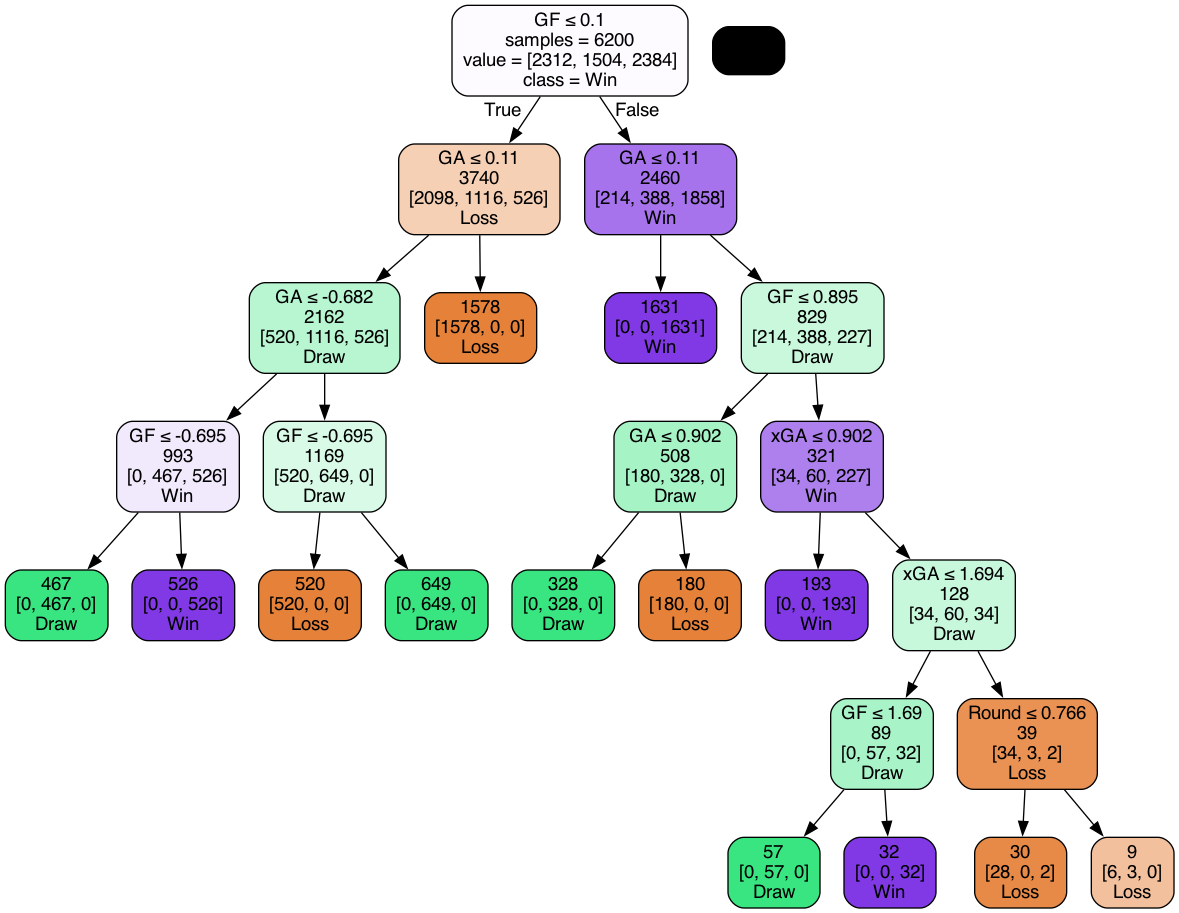

In [85]:
plotDecisionTree(dtm,
                 feature_names=unique_predictors,
                 class_names=['Loss', 'Draw', 'Win'])

**Testing the Random Forest Model**

In [86]:
rfm.fit(X_train, y_train)
y_pred_rfm = rfm.predict(X_test)

rfm.score(X_train, y_train)

0.9935483870967742

In [87]:
print(classification_report(y_test, y_pred_rfm))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       678
           1       0.99      0.96      0.97       410
           2       0.99      0.99      0.99       680

    accuracy                           0.99      1768
   macro avg       0.99      0.98      0.99      1768
weighted avg       0.99      0.99      0.99      1768



The models have all tested perfectly. However, the features used for prediction are mostly information that is only available after the match. We'll use rolling averages to aggregate the technical features and then re-test the model.

###  Improving the Model with Rolling Averages

In [165]:
def rolling_averages(group, cols, new_cols):
    group = group.sort_values("Date")
    rolling_stats = group[cols].rolling(21, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group

In [166]:
new_cols = [f"{c}_rolling" for c in unique_predictors]

In [167]:
df_rolling = df.groupby('Team').apply(lambda x: rolling_averages(x, unique_predictors, new_cols))
df_rolling = df_rolling.droplevel('Team').reset_index().drop(columns='index')

df_rolling.head()

,Season,Team,Date,Time,Comp,Round,Day,Venue,Result,GF,...,PK_rolling,G-xG_rolling,Formation_Code_rolling,GF_rolling,Sh_rolling,Round_rolling,G/Sh_rolling,SoT_rolling,Day_Code_rolling,xG_rolling
0,2012-2013,Arsenal,2013-01-20,NaN,Premier League,23,Sun,Away,L,1.0,...,0.142857,0.0,12.0,1.904762,0.0,11.142857,0.0,0.0,4.619048,0.0
1,2012-2013,Arsenal,2013-01-23,NaN,Premier League,19,Wed,Home,W,5.0,...,0.142857,0.0,12.0,1.952381,0.0,12.190476,0.0,0.0,4.666667,0.0
2,2012-2013,Arsenal,2013-01-30,NaN,Premier League,24,Wed,Home,D,2.0,...,0.142857,0.0,12.0,2.190476,0.0,13.000000,0.0,0.0,4.476190,0.0
3,2012-2013,Arsenal,2013-02-02,NaN,Premier League,25,Sat,Home,W,1.0,...,0.142857,0.0,12.0,2.190476,0.0,14.000000,0.0,0.0,4.285714,0.0
4,2012-2013,Arsenal,2013-02-09,NaN,Premier League,26,Sat,Away,W,1.0,...,0.142857,0.0,12.0,1.952381,0.0,15.000000,0.0,0.0,4.285714,0.0


In [168]:
df_rolling.columns

Index(['Season', 'Team', 'Date', 'Time', 'Comp', 'Round', 'Day', 'Venue',
       'Result', 'GF', 'GA', 'Opponent', 'xG', 'xGA', 'Poss', 'Attendance',
       'Captain', 'Formation', 'Referee', 'Match Report', 'Notes', 'Gls', 'Sh',
       'SoT', 'SoT%', 'G/Sh', 'G/SoT', 'Dist', 'FK', 'PK', 'PKatt', 'npxG',
       'npxG/Sh', 'G-xG', 'np:G-xG', 'Venue_Code', 'Opp_Code', 'Hour',
       'Day_Code', 'Formation_Code', 'Result_Code', 'FK_rolling', 'GA_rolling',
       'xGA_rolling', 'np:G-xG_rolling', 'Attendance_rolling',
       'npxG/Sh_rolling', 'Hour_rolling', 'npxG_rolling', 'Venue_Code_rolling',
       'Opp_Code_rolling', 'Dist_rolling', 'G/SoT_rolling', 'SoT%_rolling',
       'Gls_rolling', 'PKatt_rolling', 'Poss_rolling', 'PK_rolling',
       'G-xG_rolling', 'Formation_Code_rolling', 'GF_rolling', 'Sh_rolling',
       'Round_rolling', 'G/Sh_rolling', 'SoT_rolling', 'Day_Code_rolling',
       'xG_rolling'],
      dtype='object')

In [169]:
rolling_pred = ['Venue_Code', 'Opp_Code', 'Hour', 'Day_Code', 'PK_rolling',
                'Day_Code_rolling', 'Attendance_rolling', 'Hour_rolling',
                'G-xG_rolling', 'G/SoT_rolling', 'Gls_rolling', 'Sh_rolling',
                'G/Sh_rolling', 'np:G-xG_rolling', 'Formation_Code_rolling',
                'GA_rolling', 'Dist_rolling', 'xGA_rolling', 'Poss_rolling',
                'Round_rolling', 'PKatt_rolling', 'npxG/Sh_rolling',
                'GF_rolling', 'npxG_rolling', 'SoT%_rolling', 
                'Venue_Code_rolling', 'xG_rolling', 'SoT_rolling']

In [170]:
test_index = list(df_rolling.loc[df_rolling['Date'].dt.year >= 2021].index)
train_index = list(df_rolling.loc[df_rolling['Date'].dt.year < 2021].index)

X_train, X_test = df_rolling[rolling_pred].iloc[train_index, :], df_rolling[rolling_pred].iloc[test_index,:]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [171]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

X_train[:5]

array([[-1.00090408, -0.94461656, -2.07233417,  0.88964028,  0.56465212,
         0.45514244, -1.66555681, -2.01999411, -0.06712631, -1.82966039,
         0.88297539, -1.88029572, -1.75634737, -0.07345763, -0.38003196,
        -0.53158905, -0.84599999, -0.53158905, -1.93549308, -1.71895591,
        -1.02985611, -0.83197413,  1.06656818, -0.79986538, -1.96238003,
        -0.78032425, -0.79910244, -1.77020721],
       [ 0.99909674,  1.49200975, -2.07233417, -1.40143707,  0.56465212,
         0.58431268, -1.66555681, -2.01999411, -0.06712631, -1.82966039,
         0.98517615, -1.88029572, -1.75634737, -0.07345763, -0.38003196,
        -0.27492146, -0.84599999, -0.27492146, -1.93549308, -1.50592467,
        -1.02985611, -0.83197413,  1.16627625, -0.79986538, -1.96238003,
        -2.3223007 , -0.79910244, -1.77020721],
       [ 0.99909674, -0.16489614, -2.07233417, -1.40143707,  0.56465212,
         0.0676317 , -1.66555681, -2.01999411, -0.06712631, -1.82966039,
         1.49617994, -1.8802

In [172]:
X_train = pd.DataFrame(X_train, columns=rolling_pred)
X_train.head()

,Venue_Code,Opp_Code,Hour,Day_Code,PK_rolling,Day_Code_rolling,Attendance_rolling,Hour_rolling,G-xG_rolling,G/SoT_rolling,...,Poss_rolling,Round_rolling,PKatt_rolling,npxG/Sh_rolling,GF_rolling,npxG_rolling,SoT%_rolling,Venue_Code_rolling,xG_rolling,SoT_rolling
0,-1.000904,-0.944617,-2.072334,0.889640,0.564652,0.455142,-1.665557,-2.019994,-0.067126,-1.82966,...,-1.935493,-1.718956,-1.029856,-0.831974,1.066568,-0.799865,-1.96238,-0.780324,-0.799102,-1.770207
1,0.999097,1.492010,-2.072334,-1.401437,0.564652,0.584313,-1.665557,-2.019994,-0.067126,-1.82966,...,-1.935493,-1.505925,-1.029856,-0.831974,1.166276,-0.799865,-1.96238,-2.322301,-0.799102,-1.770207
2,0.999097,-0.164896,-2.072334,-1.401437,0.564652,0.067632,-1.665557,-2.019994,-0.067126,-1.82966,...,-1.935493,-1.341310,-1.029856,-0.831974,1.664817,-0.799865,-1.96238,-0.780324,-0.799102,-1.770207
3,0.999097,0.907219,-2.072334,0.316871,0.564652,-0.449049,-1.665557,-2.019994,-0.067126,-1.82966,...,-1.935493,-1.137962,-1.029856,-0.831974,1.664817,-0.799865,-1.96238,0.761652,-0.799102,-1.770207
4,-1.000904,1.004684,-2.072334,0.316871,0.564652,-0.449049,-1.665557,-2.019994,-0.067126,-1.82966,...,-1.935493,-0.934614,-1.029856,-0.831974,1.166276,-0.799865,-1.96238,0.761652,-0.799102,-1.770207


In [173]:
X_test = pd.DataFrame(X_test, columns=rolling_pred)
X_test.head()

,Venue_Code,Opp_Code,Hour,Day_Code,PK_rolling,Day_Code_rolling,Attendance_rolling,Hour_rolling,G-xG_rolling,G/SoT_rolling,...,Poss_rolling,Round_rolling,PKatt_rolling,npxG/Sh_rolling,GF_rolling,npxG_rolling,SoT%_rolling,Venue_Code_rolling,xG_rolling,SoT_rolling
0,-0.999419,1.567883,1.496126,0.358062,1.013613,0.220873,-1.320585,1.889971,-0.229154,-0.323612,...,0.114464,-0.775698,0.549939,0.964732,-0.553260,-0.650490,0.291392,0.805668,-0.503776,-0.913275
1,1.000581,-0.668165,1.496126,-0.742338,1.013613,0.690161,-1.320585,1.889971,-0.147823,-0.186788,...,0.254112,-0.942185,0.549939,1.245342,-0.273816,-0.280391,0.148985,-0.799141,-0.158855,-0.715010
2,1.000581,0.401249,1.496126,-2.392938,1.013613,0.338195,-1.320585,2.184520,-0.310485,-0.342269,...,0.285850,-1.108671,0.549939,1.210266,-0.366964,-0.308860,0.220189,0.805668,-0.185387,-0.715010
3,-0.999419,0.984566,1.496126,-1.842738,1.013613,0.103551,-1.320585,2.184520,-0.432482,-0.653233,...,0.501670,-1.275158,0.549939,0.684121,-0.273816,-0.081106,-0.246450,0.805668,0.026872,-0.516745
4,1.000581,0.206810,0.299642,0.358062,1.013613,0.103551,-1.320585,2.184520,-0.147823,-0.186788,...,0.330284,-1.441644,0.549939,1.210266,0.005629,0.146647,0.318094,0.805668,0.239130,-0.318480


In [ ]:
# imp = SimpleImputer(missing_values=np.nan,
#                     strategy='constant',
#                     fill_value= 0)

# X_train = imp.fit_transform(X_train).astype(float)
# X_test = imp.fit_transform(X_test).astype(float)



# X_train.head()

In [174]:
knnm = KNeighborsClassifier()
params = {"n_neighbors": range(1, 50),
          'weights':['uniform', 'distance'],
          "metric": ["minkowski", "manhattan"]}

grid_recall = GridSearchCV(knnm, params,
                           scoring='accuracy', n_jobs=-1)

grid_recall.fit(X_train, y_train)
best_params = grid_recall.best_params_
best_score = grid_recall.best_score_
best_estimator = grid_recall.best_estimator_

print(best_params)
print(best_score)
print(best_estimator)

{'metric': 'manhattan', 'n_neighbors': 27, 'weights': 'uniform'}
0.3630998528189019
KNeighborsClassifier(metric='manhattan', n_neighbors=27)


In [175]:
rfm = RandomForestClassifier()
params = {'criterion': ['gini', 'entropy'],
          'n_estimators':[50, 70, 100, 150],
          'class_weight': [None, 'balanced'],
          'min_samples_split': list(range(12, 48, 3)),
          'max_depth': list(range(3, 7)),
          'min_samples_leaf': list(range(9, 19, 3))}

class_tree= RandomForestClassifier(random_state=24)
random_recall = RandomizedSearchCV(rfm,
                                   param_distributions=params,
                                   scoring='accuracy',
                                   n_iter=10,
                                   cv=9,
                                   n_jobs=-1)

random_recall.fit(X_train, y_train)
best_params = random_recall.best_params_
best_score = random_recall.best_score_
best_estimator = random_recall.best_estimator_

print(best_params)
print(best_score)
print(best_estimator)

{'n_estimators': 50, 'min_samples_split': 30, 'min_samples_leaf': 9, 'max_depth': 4, 'criterion': 'gini', 'class_weight': None}
0.356599254374737
RandomForestClassifier(max_depth=4, min_samples_leaf=9, min_samples_split=30,
                       n_estimators=50)


In [128]:
rfm = RandomForestClassifier(criterion='entropy', max_depth=3, min_samples_leaf=9,
                             min_samples_split=24, n_estimators=50)
forward = SequentialFeatureSelector(estimator=rfm,
                                    n_features_to_select=10,
                                    direction="forward")
forward.fit(X_train, y_train)
rf_ff = forward.get_feature_names_out()
print('Forward Features: ', rf_ff)



backward = SequentialFeatureSelector(estimator=rfm,
                                     n_features_to_select=10,
                                     direction="backward")
backward.fit(X_train, y_train)
rf_bb = backward.get_feature_names_out()
print('Backward Features: ', rf_bb)

Forward Features:  ['Venue_Code' 'Day_Code' 'PK_rolling' 'Gls_rolling' 'Round_rolling'
 'PKatt_rolling' 'npxG_rolling' 'Venue_Code_rolling' 'xG_rolling'
 'SoT_rolling']
Backward Features:  ['Hour' 'Day_Code' 'G/SoT_rolling' 'Gls_rolling' 'np:G-xG_rolling'
 'Dist_rolling' 'Round_rolling' 'npxG_rolling' 'SoT%_rolling'
 'Venue_Code_rolling']


In [112]:
lrm.fit(X_train, y_train)
y_pred_lrm = lrm.predict(X_test)

lrm.score(X_train, y_train)

0.4044888597640891

In [113]:
print(classification_report(y_test, y_pred_lrm))

              precision    recall  f1-score   support

           0       0.36      0.46      0.40       632
           1       0.41      0.03      0.05       470
           2       0.38      0.53      0.45       660

    accuracy                           0.37      1762
   macro avg       0.38      0.34      0.30      1762
weighted avg       0.38      0.37      0.33      1762



In [114]:
knnm.fit(X_train, y_train)
y_pred_knnm = knnm.predict(X_test)

knnm.score(X_train, y_train)

0.9649410222804718

In [115]:
print(classification_report(y_test, y_pred_knnm))

              precision    recall  f1-score   support

           0       0.34      0.41      0.37       632
           1       0.30      0.12      0.17       470
           2       0.36      0.45      0.40       660

    accuracy                           0.34      1762
   macro avg       0.33      0.32      0.31      1762
weighted avg       0.34      0.34      0.33      1762



In [124]:
svcm.fit(X_train, y_train)
y_pred_svcm = svcm.predict(X_test)

svcm.score(X_train, y_train)

0.40219528178243774

In [125]:
print(classification_report(y_test, y_pred_svcm))

              precision    recall  f1-score   support

           0       0.36      0.47      0.41       632
           1       0.00      0.00      0.00       470
           2       0.38      0.53      0.44       660

    accuracy                           0.37      1762
   macro avg       0.25      0.33      0.28      1762
weighted avg       0.27      0.37      0.31      1762



In [116]:
sgdm.fit(X_train, y_train)
y_pred_sgdm = sgdm.predict(X_test)

sgdm.score(X_train, y_train)

0.37729357798165136

In [117]:
print(classification_report(y_test, y_pred_sgdm))

              precision    recall  f1-score   support

           0       0.35      0.24      0.29       632
           1       0.34      0.02      0.04       470
           2       0.38      0.74      0.50       660

    accuracy                           0.37      1762
   macro avg       0.36      0.33      0.28      1762
weighted avg       0.36      0.37      0.30      1762



In [118]:
gnbm.fit(X_train, y_train)
y_pred_gnbm = gnbm.predict(X_test)

gnbm.score(X_train, y_train)

0.3863040629095675

In [119]:
print(classification_report(y_test, y_pred_gnbm))

              precision    recall  f1-score   support

           0       0.37      0.25      0.30       632
           1       0.29      0.10      0.15       470
           2       0.40      0.70      0.51       660

    accuracy                           0.38      1762
   macro avg       0.35      0.35      0.32      1762
weighted avg       0.36      0.38      0.34      1762



In [120]:
dtm.fit(X_train, y_train)
y_pred_dtm = dtm.predict(X_test)

dtm.score(X_train, y_train)

0.4169397116644823

In [121]:
print(classification_report(y_test, y_pred_dtm))

              precision    recall  f1-score   support

           0       0.36      0.14      0.20       632
           1       0.26      0.05      0.09       470
           2       0.38      0.81      0.51       660

    accuracy                           0.37      1762
   macro avg       0.33      0.33      0.27      1762
weighted avg       0.34      0.37      0.29      1762



In [122]:
rfm.fit(X_train, y_train)
y_pred_rfm = rfm.predict(X_test)

rfm.score(X_train, y_train)

0.48410878112712974

In [123]:
print(classification_report(y_test, y_pred_rfm))

              precision    recall  f1-score   support

           0       0.36      0.33      0.34       632
           1       0.43      0.01      0.01       470
           2       0.38      0.67      0.48       660

    accuracy                           0.37      1762
   macro avg       0.39      0.34      0.28      1762
weighted avg       0.38      0.37      0.31      1762



### Conclusion
The models predict perfectly where they have the actual stats from the game to train & predict with. Where we don't (e.g. in the case of future unplayed matches) and we try to predict using rolling averages, the models' accuracy drop by nearly 70%. Our best test accuracy is 37%. Recall is generally poor, especially for 'Draw' predictions. All models predict 'Win' values best. It might be important to check how balanced the target classes are.

Here are some potential next steps:
* Get additional data for more Premier League seasons to improve the model
* Create extra predictors by using more of the columns in the data
* Try making predictions for a different league
* Use data from additional competitions outside the Premier League
* Look at opponent rolling averages and use them as predictor columns
* Try out different algorithms.